# Introduction

The following notebook shows the deep learning-based version. A CNN is built and used as a binary claffisifier to predict whether it is offside or not.

#Import

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Train set, validation set, test set

The CV based algorithm was used to split the classes and the 3 sets. Below the datasets are loaded and the data distribution is shown for each set.

In [ ]:
train_path ="/content/drive/MyDrive/AIRO/Computer Vision/Offside Detection/Training"
val_path = "/content/drive/MyDrive/AIRO/Computer Vision/Offside Detection/Validation"
test_path = "/content/drive/MyDrive/AIRO/Computer Vision/Offside Detection/Test"

Offside found: train=3826, val=487, test=481
Inside found: train=4174, val=513, test=519


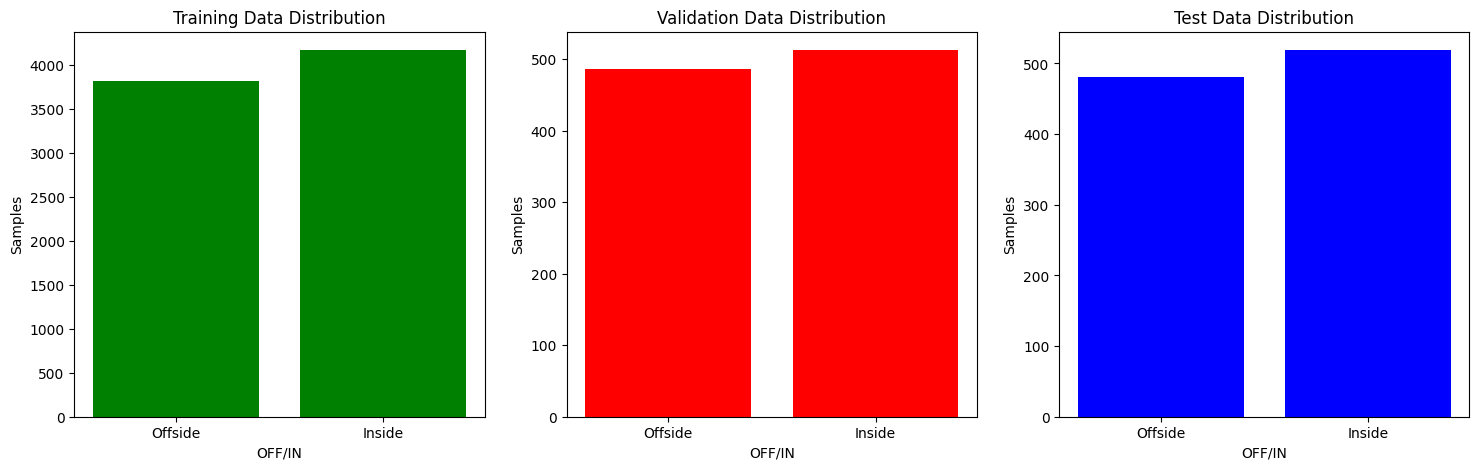

In [ ]:
offside_train = len(os.listdir(os.path.join(train_path, "Offside")))
inside_train = len(os.listdir(os.path.join(train_path, "Inside")))

offside_val = len(os.listdir(os.path.join(val_path, "Offside")))
inside_val = len(os.listdir(os.path.join(val_path, "Inside")))

offside_test = len(os.listdir(os.path.join(test_path, "Offside")))
inside_test = len(os.listdir(os.path.join(test_path, "Inside")))

print(f"Offside found: train={offside_train}, val={offside_val}, test={offside_test}")
print(f"Inside found: train={inside_train}, val={inside_val}, test={inside_test}")

x = ['Offside', 'Inside']
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
y = [offside_train, inside_train]
plt.bar(x, y, align="center", color="green")
plt.ylabel('Samples')
plt.xlabel('OFF/IN')
plt.title('Training Data Distribution')

plt.subplot(1,3,2)
y = [offside_val, inside_val]
plt.bar(x, y, align="center", color="red")
plt.ylabel('Samples')
plt.xlabel('OFF/IN')
plt.title('Validation Data Distribution')

plt.subplot(1,3,3)
y = [offside_test, inside_test]
plt.bar(x, y, align="center", color="blue")
plt.ylabel('Samples')
plt.xlabel('OFF/IN')
plt.title('Test Data Distribution')

plt.show()

# Learning

Two approaches based on the same model are shown below, but in the second, regularization techniques are introduced which have the aim of improving performance. Let's start with the version without these techniques.

## Initialization

With the **ImageDataGenerator** function we define the train and validation generator which allows us to:

1) Read images from the disk.

2) Decode contents of these images and convert it into proper grid format as per their RGB content.

3) Convert them into floating point tensors.

4) Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

In [ ]:
train = ImageDataGenerator(rescale=1/255)
validation = ImageDataGenerator(rescale=1/255)

Now, we can import from the right directory the data with **flow_from_directory** function. It also sets the batch_size and class_mode.
For the training set we use a batch_size of 256 while for the validation set we use a batch_size of 64. Both of them has as class_mode the attribute binary, because the result of the cnn work is a binary classification: Offside, Inside.

In [ ]:
training_set = train.flow_from_directory(train_path,
                                         target_size= (150,150),
                                         batch_size = 256,
                                         class_mode = 'binary')

validation_set = train.flow_from_directory(val_path,
                                         target_size= (150,150),
                                         batch_size = 64,
                                         class_mode = 'binary')

Found 8000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Labels:


*   Inside: 0
*   Offside: 1

In [ ]:
training_set.class_indices

{'Inside': 0, 'Offside': 1}

## Model

Below the structure of the CNN is shown. It has:


*   **3 Convolutional Layers:** the filter is a 3x3 matrix and 32, 64 and 128 as dimensionality of the output space according to the first, second and third layer. Each convolutional operation is followed by an activation function (relu)
*   **3 MaxPooling Layers**: they follow each convolutional layer and help in reducing the spatial dimensions. It's used a 2x2 matrix to store the max pool operation
*   The **Flatten Layer** converts the multi-dimensional image data array to 1D array
*   **2 Dense Layers**: the first one has 512 as units value, it means that 512 is the output dimensionality and uses relu as activation function; the second one has 1 as units value, it means that it produces a single output which represents the predicted label. Since this is a binary classification task the sigmoid function is used as activation.

In [ ]:
model = Sequential( [Conv2D(32, (3,3), activation = 'relu', input_shape = (150,150,3)),
                     MaxPooling2D(2,2),

                     Conv2D(64, (3,3), activation='relu'),
                     MaxPooling2D(2,2),

                     Conv2D(128, (3,3), activation ='relu'),
                     MaxPooling2D(2,2),

                     Flatten(),

                     Dense(512, activation='relu'),

                     Dense(1, activation='sigmoid')
                     ])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 17, 17, 128)      

*    It's used as loss the binary cross entropy loss and Adam as optimizer. Learning rate is set to 0.001.
*    To avoid inefficient computation time and space we use the Early Stopping method which stops the model process if the validation accuracy (in this case) doesn't decrement its value for n times and once it's stopped it restores the best weights.

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics='accuracy')
callback = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

## Training

In [ ]:
model_fit = model.fit(training_set,
                      steps_per_epoch = 3,
                      epochs = 30,
                      callbacks=[callback],
                      validation_data = validation_set)

Epoch 1/30
3/3 [==============================] - 15s 3s/step - loss: 1.3747 - accuracy: 0.5195 - val_loss: 0.8620 - val_accuracy: 0.4870
Epoch 2/30
3/3 [==============================] - 13s 6s/step - loss: 0.7599 - accuracy: 0.5065 - val_loss: 0.6947 - val_accuracy: 0.5130
Epoch 3/30
3/3 [==============================] - 13s 6s/step - loss: 0.6934 - accuracy: 0.5404 - val_loss: 0.6925 - val_accuracy: 0.5130
Epoch 4/30
3/3 [==============================] - 8s 3s/step - loss: 0.6919 - accuracy: 0.5286 - val_loss: 0.6917 - val_accuracy: 0.5130
Epoch 5/30
3/3 [==============================] - 8s 4s/step - loss: 0.6911 - accuracy: 0.6458 - val_loss: 0.6913 - val_accuracy: 0.5130
Epoch 6/30
3/3 [==============================] - 8s 4s/step - loss: 0.6905 - accuracy: 0.4961 - val_loss: 0.6852 - val_accuracy: 0.6640
Epoch 7/30
3/3 [==============================] - 8s 3s/step - loss: 0.6838 - accuracy: 0.6380 - val_loss: 0.6778 - val_accuracy: 0.5230
Epoch 8/30
3/3 [======================

## Result

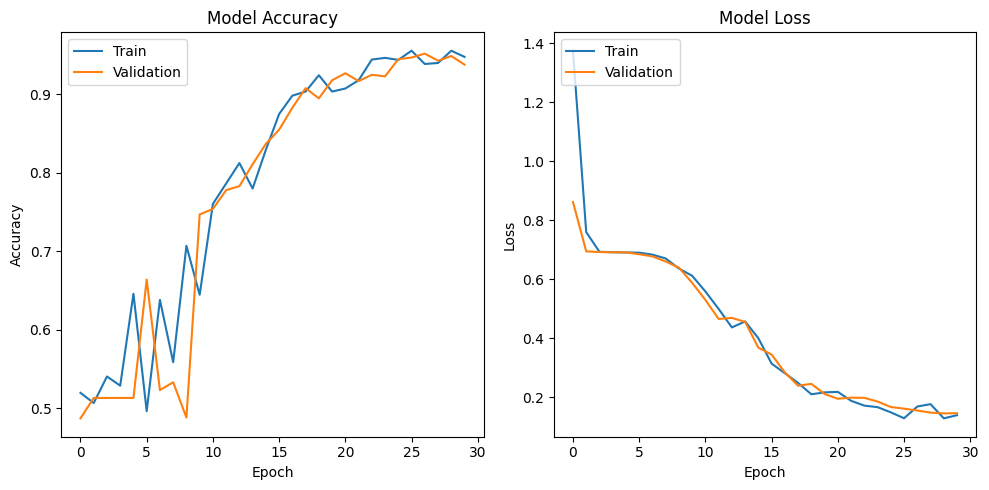

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(model.history.history['accuracy'])
ax1.plot(model.history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

ax2.plot(model.history.history['loss'])
ax2.plot(model.history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
def network_test():

  in_path = "/content/drive/MyDrive/AIRO/Computer Vision/Offside Detection/Test/Inside"
  off_path = "/content/drive/MyDrive/AIRO/Computer Vision/Offside Detection/Test/Offside"

  img_inside = os.listdir(in_path)
  img_offside = os.listdir(off_path)

  dim_inside = len(img_inside)
  dim_offside = len(img_offside)

  TP = 0
  TN = 0
  FP = 0
  FN = 0

  for i in img_inside:
    img = load_img(in_path+"/"+str(i), target_size=(150,150,3))
    X = img_to_array(img)
    X = np.expand_dims(X, axis=0)
    images = np.vstack([X])
    val = model.predict(images)
    if val == 0:
      TP+=1
    else:
      FP+=1

  for i in img_offside:
    img = load_img(off_path+"/"+str(i), target_size=(150,150,3))
    X = img_to_array(img)
    X = np.expand_dims(X, axis=0)
    images = np.vstack([X])
    val = model.predict(images)
    if val == 0:
      FN += 1
    else:
      TN += 1

  correct = TP+TN
  total_dim = dim_inside+dim_offside

  test_acc = correct/total_dim

  return test_acc, TP, TN, FP, FN

In [ ]:
acc, TP, TN, FP, FN = network_test()

1/1 [==============================] - 0s 18ms/step


Defining as:


*   TP (true positive): Inside correctly classified as Inside
*   TN (true negative): Offside correctly classified as Offside
*   FP (false positive): Offside wrongly classified as Inside
*   FN (false negative): Inside wrongly classified as Offside

Let's print a bar with these values:

Test accuracy:  0.922


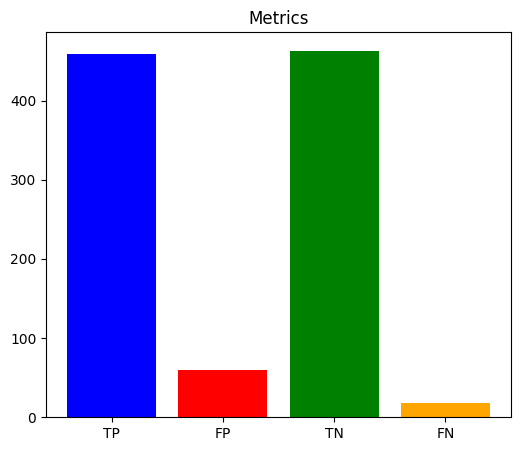

In [ ]:
print("Test accuracy: ", acc)
y = [TP, FP, TN, FN]
x = ['TP', 'FP', 'TN', 'FN']
plt.figure(figsize=(6,5))
plt.bar(x, y, align="center", color=["blue", "red", "green", "orange"])
plt.title('Metrics')
plt.show()

Let's also print a confusion with these values:

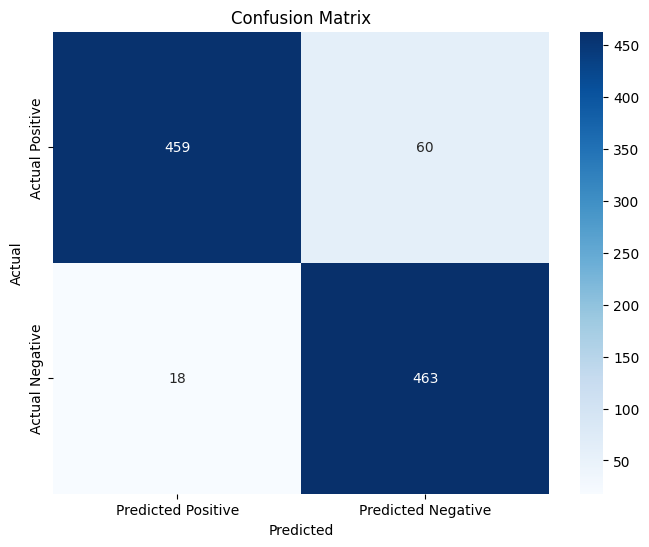

In [ ]:
conf_matrix = np.array([[TP, FP], [FN, TN]])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Positive', 'Predicted Negative'], yticklabels=['Actual Positive', 'Actual Negative'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
precision = TP/(TP + FP)
recall = TP/(TP + FN)
f1_score = 2*(precision*recall)/(precision+recall)
print("PRECISION: ", precision)
print("RECALL: ", recall)
print("F1-SCORE: ", f1_score)

PRECISION:  0.884393063583815
RECALL:  0.9622641509433962
F1-SCORE:  0.9216867469879518


## Regularization Techniques

As a regularization Techniques we used a **Data Augmentation** and **Dropout**.

The first, is used in order to:
*  increase the model's ability to generalize
*  add variability to the data and minimize data overfitting
*  save on the cost of collecting and labeling additional data
*  improve the accuracy of the deep learning model's predictions

The second works by randomly "dropping out" a fraction of the neurons or units in a neural network during training. This means that during each training iteration, a random subset of neurons is temporarily ignored or "turned off." In this case Drop Out rate is 0.5 and it is applied after the Dense Layer. Also, by forcing the network to learn from a subset of neurons at each iteration, dropout promotes the learning of more diverse and independent features, improving the network's ability to generalize to new, unseen data.

### Initialization

In [ ]:
train = ImageDataGenerator(
        rescale=1/255,
        zoom_range=0.1,
        brightness_range=[0.9, 1.1],
        fill_mode='nearest'
)
validation = ImageDataGenerator(
             rescale=1/255,
             zoom_range=0.1,
             brightness_range=[0.9, 1.1],
             fill_mode='nearest'
)

In [ ]:
training_set = train.flow_from_directory(train_path,
                                         target_size= (150,150),
                                         batch_size = 256,
                                         class_mode = 'binary')

validation_set = train.flow_from_directory(val_path,
                                         target_size= (150,150),
                                         batch_size = 64,
                                         class_mode = 'binary')

Found 8000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
training_set.class_indices

{'Inside': 0, 'Offside': 1}

### Model

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 17, 17, 128)      

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics='accuracy')
callback = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

### Training

In [ ]:
model_fit = model.fit(training_set,
                      steps_per_epoch = 3,
                      epochs = 50,
                      callbacks=[callback],
                      validation_data = validation_set)

Epoch 1/50
3/3 [==============================] - 30s 11s/step - loss: 1.4392 - accuracy: 0.5078 - val_loss: 0.7180 - val_accuracy: 0.4870
Epoch 2/50
3/3 [==============================] - 39s 17s/step - loss: 0.8047 - accuracy: 0.5208 - val_loss: 0.7028 - val_accuracy: 0.5130
Epoch 3/50
3/3 [==============================] - 26s 10s/step - loss: 0.6999 - accuracy: 0.5456 - val_loss: 0.6909 - val_accuracy: 0.6420
Epoch 4/50
3/3 [==============================] - 39s 16s/step - loss: 0.6891 - accuracy: 0.6380 - val_loss: 0.6848 - val_accuracy: 0.6640
Epoch 5/50
3/3 [==============================] - 25s 10s/step - loss: 0.6797 - accuracy: 0.6528 - val_loss: 0.6982 - val_accuracy: 0.5130
Epoch 6/50
3/3 [==============================] - 25s 10s/step - loss: 0.6775 - accuracy: 0.5443 - val_loss: 0.6585 - val_accuracy: 0.7240
Epoch 7/50
3/3 [==============================] - 27s 11s/step - loss: 0.6434 - accuracy: 0.7513 - val_loss: 0.6180 - val_accuracy: 0.7250
Epoch 8/50
3/3 [===========

### Final results

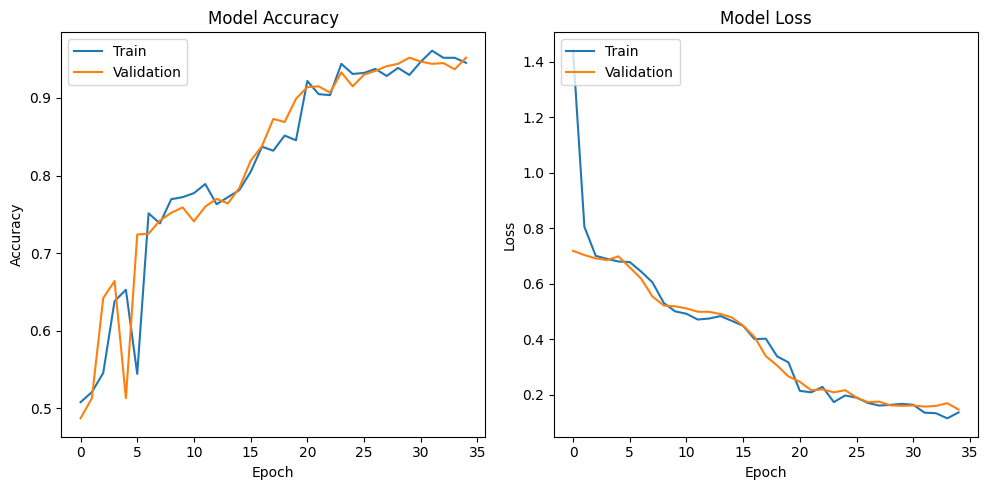

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(model.history.history['accuracy'])
ax1.plot(model.history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

ax2.plot(model.history.history['loss'])
ax2.plot(model.history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
def network_test():

  in_path = "/content/drive/MyDrive/AIRO/Computer Vision/Offside Detection/Test/Inside"
  off_path = "/content/drive/MyDrive/AIRO/Computer Vision/Offside Detection/Test/Offside"

  img_inside = os.listdir(in_path)
  img_offside = os.listdir(off_path)

  dim_inside = len(img_inside)
  dim_offside = len(img_offside)

  TP = 0
  TN = 0
  FP = 0
  FN = 0

  for i in img_inside:
    img = load_img(in_path+"/"+str(i), target_size=(150,150,3))
    X = img_to_array(img)
    X = np.expand_dims(X, axis=0)
    images = np.vstack([X])
    val = model.predict(images)
    if val == 0:
      TP+=1
    else:
      FP+=1

  for i in img_offside:
    img = load_img(off_path+"/"+str(i), target_size=(150,150,3))
    X = img_to_array(img)
    X = np.expand_dims(X, axis=0)
    images = np.vstack([X])
    val = model.predict(images)
    if val == 0:
      FN += 1
    else:
      TN += 1

  correct = TP+TN
  total_dim = dim_inside+dim_offside

  test_acc = correct/total_dim

  return test_acc, TP, TN, FP, FN

In [ ]:
acc, TP, TN, FP, FN = network_test()

1/1 [==============================] - 0s 34ms/step


Test accuracy:  0.949


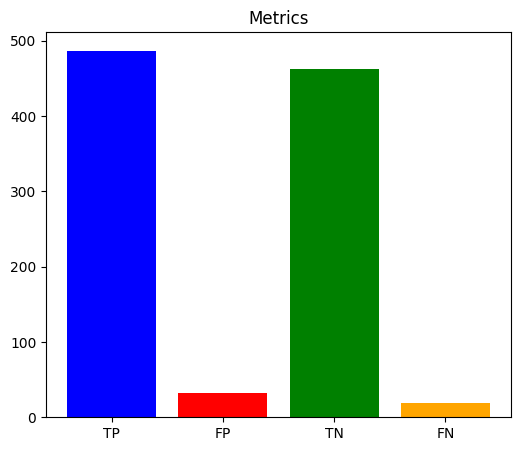

In [ ]:
print("Test accuracy: ", acc)
y = [TP, FP, TN, FN]
x = ['TP', 'FP', 'TN', 'FN']
plt.figure(figsize=(6,5))
plt.bar(x, y, align="center", color=["blue", "red", "green", "orange"])
plt.title('Metrics')
plt.show()

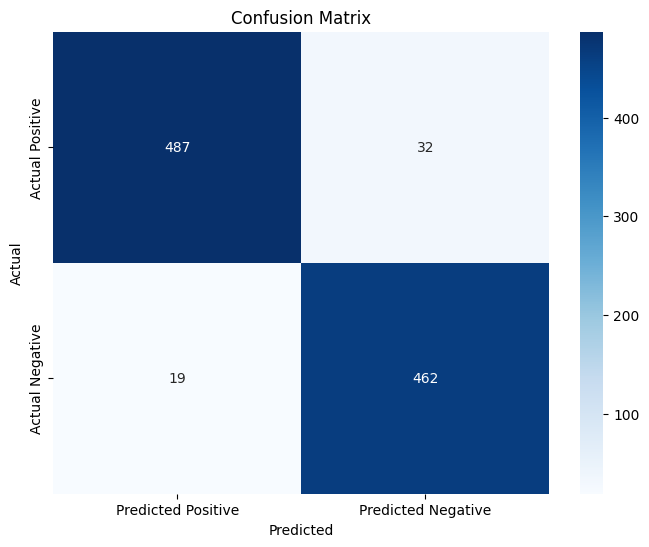

In [ ]:
conf_matrix = np.array([[TP, FP], [FN, TN]])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Positive', 'Predicted Negative'], yticklabels=['Actual Positive', 'Actual Negative'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
precision = TP/(TP + FP)
recall = TP/(TP + FN)
f1_score = 2*(precision*recall)/(precision+recall)
print("PRECISION: ", precision)
print("RECALL: ", recall)
print("F1-SCORE: ", f1_score)

PRECISION:  0.9383429672447013
RECALL:  0.9624505928853755
F1-SCORE:  0.9502439024390245
